In [36]:
import numpy as np 
import sympy as sym
from sympy.utilities.lambdify import lambdify, implemented_function
from imp import reload
import numba 
sin = sym.sin
cos = sym.cos

In [37]:
delta, omega, e1d, e1q = sym.symbols('delta omega e1d e1q')
i_d, i_q, v_d, v_q = sym.symbols('i_d i_q v_d v_q')
v_f, p_m = sym.symbols('v_f p_m')
X_d, X_q, X1d, X1q, X_l, R_a, T1d0, T1q0  = sym.symbols('X_d X_q X1d X1q X_l R_a T1d0 T1q0')
H, D = sym.symbols('H D')
V_t, theta_t, P_t, Q_t, V_inf, theta_inf = sym.symbols('V_t, theta_t, P_t, Q_t, V_inf, theta_inf')
B_t_inf, B_t0, G_t_inf, G_t0 = sym.symbols('B_t_inf, B_t0, G_t_inf, G_t0')
Omega_b, p_e = sym.symbols('Omega_b p_e')

## Initialization problem (backward)

In [38]:
N_x = 4
N_y = 9
ddelta = Omega_b * (omega - 1);
domega = 1/(2*H) * ( p_m - p_e - D * ( omega - 1)) ;
de1q   = 1/T1d0 * ( -e1q - (X_d - X1d ) * i_d + v_f);
de1d   = 1/T1q0 * ( -e1d + (X_q - X1q ) * i_q );

g1 = v_q + R_a * i_q - e1q + (X1d - X_l)*i_d;
g2 = v_d + R_a * i_d - e1d - (X1q - X_l)*i_q;
g3 = p_e - (v_q + R_a*i_q)*i_q - (v_d + R_a*i_d)*i_d ;
g4 = v_d - V_t * sin(delta - theta_t);
g5 = v_q - V_t * cos(delta - theta_t);
g6 = v_d * i_d + v_q * i_q - P_t; 
g7 = v_q * i_d - v_d * i_q - Q_t;
g8 =  V_t**2*(G_t_inf+G_t0) - V_t*V_inf*(G_t_inf * cos(theta_t - theta_inf) + B_t_inf * sin(theta_t - theta_inf)) - P_t  
g9 = -V_t**2*(B_t_inf+B_t0) - V_t*V_inf*(G_t_inf * sin(theta_t - theta_inf) - B_t_inf * cos(theta_t - theta_inf)) - Q_t  

In [39]:
x = sym.Matrix([delta,omega,e1q,e1d])
f = sym.Matrix([ddelta, domega, de1q, de1d])

y = sym.Matrix([i_d,i_q,p_e,v_d,v_q,p_m,v_f,theta_t,Q_t])
g = sym.Matrix([g1, g2, g3, g4, g5, g6, g7,g8,g9])

In [40]:
F_x = f.jacobian(x)
F_y = f.jacobian(y)
G_x = g.jacobian(x)
G_y = g.jacobian(y)

In [41]:
X_d = 1.81
X1d  = 0.3
T1d0  = 8.0
X_q  = 1.76
X1q  = 0.65
T1q0  = 1.0 
R_a  =  0.003 
X_l  = 0.15  
H  = 3.5   
Omega_b = 2*np.pi*60
Z_t_inf = 0.15+1.0/(1.0/0.5+1.0/0.93)

params = {
'X_d':  X_d,
'X1d':  X1d,
'T1d0': T1d0,
'X_q':  X_q,
'X1q':  X1q,
'T1q0': T1q0,
'R_a':  R_a,
'X_l': X_l,
'H':  H,
'D' : 0.1,
'Omega_b': Omega_b,
'B_t_inf':-1.0/Z_t_inf,
'B_t0':0.0, 
'G_t_inf':0.0,
'G_t0':0.0,
'V_inf':0.90081,
'theta_inf':0.0,   
}

u = sym.Matrix([P_t,V_t])

In [105]:
def sym2num(symsystem,out_file):
    
    f = symsystem['f']
    g = symsystem['g']
    x = symsystem['x']
    y = symsystem['y']
    F_x = symsystem['F_x']
    F_y = symsystem['F_y']
    G_x = symsystem['G_x']
    G_y = symsystem['G_y']
        
    N_x = f.shape[0]
    N_y = g.shape[0]
    N_u = u.shape[0]

    ## Class
    string =  'import numpy as np\n'
    string += 'import numba\n'

    tab = '\n    '
    tab2 = '\n        ' 
    string += 'class system(object):\n'
    string += tab + 'def __init__(self,json_file=None):\n'
    string += tab2 + "self.N_x = {:d}".format(N_x)
    string += tab2 + "self.N_y = {:d}".format(N_y)
    string += tab2 + "dt_list = []"
    string += tab2 + "struct_list = []"
    string += tab2 + "dt_list += [('N_x',np.int32)]".format(N_x)
    string += tab2 + "dt_list += [('N_y',np.int32)]".format(N_y)
    string += tab2 + "struct_list += [{:d}]".format(N_x)
    string += tab2 + "struct_list += [{:d}]".format(N_y)

    string += tab2 + "dt_list += [('x',np.float64,({:d},1))]".format(N_x)
    string += tab2 + "dt_list += [('y',np.float64,({:d},1))]".format(N_y)
    string += tab2 + "dt_list += [('u',np.float64,({:d},1))]".format(N_u)
    string += tab2 + "struct_list += [np.zeros(({:d},1))]".format(N_x)
    string += tab2 + "struct_list += [np.zeros(({:d},1))]".format(N_y)
    string += tab2 + "struct_list += [np.zeros(({:d},1))]".format(N_u)

    string += tab2 + "dt_list += [('f',np.float64,({:d},1))]".format(N_x)
    string += tab2 + "dt_list += [('g',np.float64,({:d},1))]".format(N_y)
    string += tab2 + "struct_list += [np.zeros(({:d},1))]".format(N_x)
    string += tab2 + "struct_list += [np.zeros(({:d},1))]".format(N_y)

    string += tab2 + "dt_list += [('F_x',np.float64,({:d},{:d}))]".format(N_x,N_x)
    string += tab2 + "dt_list += [('F_y',np.float64,({:d},{:d}))]".format(N_x,N_y)
    string += tab2 + "dt_list += [('G_x',np.float64,({:d},{:d}))]".format(N_y,N_x)
    string += tab2 + "dt_list += [('G_y',np.float64,({:d},{:d}))]".format(N_y,N_y)

    string += tab2 + "struct_list += [np.zeros(({:d},{:d}))]".format(N_x,N_x)
    string += tab2 + "struct_list += [np.zeros(({:d},{:d}))]".format(N_x,N_y)
    string += tab2 + "struct_list += [np.zeros(({:d},{:d}))]".format(N_y,N_x)
    string += tab2 + "struct_list += [np.zeros(({:d},{:d}))]".format(N_y,N_y)


    string += "\n"
    for item in params: # constants
        string += tab2 + "dt_list += [('{:s}',np.float64)]".format(item)

    string += "\n"
    for item in params: # constants
        string += tab2 + "struct_list += [{:f}] # {:s}".format(params[item], item)

    string += tab2 + "self.struct = np.rec.array([struct_list],dtype=dt_list) \n"  


    string += tab + 'def ss(self,xi):\n'
    string += tab2 + "x = xi[0:self.N_x]"
    string += tab2 + "y = xi[self.N_x:(self.N_x+self.N_y)]"
    string += tab2 + "self.struct['x'] = x"
    string += tab2 + "self.struct['y'] = y"
    string += tab2 + 'update(self.struct,0,0)\n'
    string += tab2 + "lam = np.vstack((self.struct['f'],self.struct['g']))"
    string += tab2 + "return lam"


    ## update funtion
    string += "\n"*3   
    string += "@numba.jit(nopython=True, cache=True)\n"    
    string += 'def update(struct,call,item):\n'

    string += "\n"
    for it in range(N_x): # dynamic states
        string += "    {:s} = struct[item]['x'][{:s},0]\n".format(str(x[it]),str(it))

    string += "\n"
    for it in range(N_y): # algebraic states
        string += "    {:s} = struct[item]['y'][{:s},0]\n".format(str(y[it]),str(it))

    string += "\n"
    for it in range(N_u): # inputs
        string += "    {:s} = struct[item]['u'][{:s},0]\n".format(str(u[it]),str(it))

    string += "\n"
    for item in params: # constants
        string += "    {:s} = struct[item]['{:s}']\n".format(item, item)


    string += "\n"
    for it in range(N_x): # dynamic equations
        string += '    d{:s} = {:s}\n'.format(str(x[it]),str(f[it]))

    string += "\n"
    for it in range(N_x): # dynamic equations
        string += "    struct[item]['f'][{:s},0] = d{:s} \n".format(str(it),str(x[it]))

    string += "\n" * 3    

    string += "\n"
    for it in range(N_y): # algebraic equations
        string += '    g_{:s} = {:s}\n'.format(str(it),str(g[it]))

    string += "\n"
    for it in range(N_y): # algebraic equations
        string += "    struct[item]['g'][{:s},0] = g_{:s} \n".format(str(it),str(it))


    string += "\n"
    for ix in range(N_x): # F_x
        for iy in range(N_x): 
            element = F_x[ix,iy]
            if element!=0:
                string += tab + "struct[item]['F_x'][{:s},{:s}] = {:s} ".format(str(ix),str(iy),str(F_x[ix,iy]))

    string += "\n"
    for ix in range(N_x): # F_y
        for iy in range(N_y): 
            element = F_y[ix,iy]
            if element!=0:
                string += tab + "struct[item]['F_y'][{:s},{:s}] = {:s} ".format(str(ix),str(iy),str(F_y[ix,iy]))

    string += "\n"
    for ix in range(N_y): # G_x
        for iy in range(N_x): 
            element = G_x[ix,iy]
            if element!=0:
                string += tab + "struct[item]['G_x'][{:s},{:s}] = {:s} ".format(str(ix),str(iy),str(G_x[ix,iy]))

    string += "\n"
    for ix in range(N_y): # G_y
        for iy in range(N_y): 
            element = G_y[ix,iy]
            if element!=0:
                string += tab + "struct[item]['G_y'][{:s},{:s}] = {:s} ".format(str(ix),str(iy),str(G_y[ix,iy]))
    string += "\n"


    replaces = [('cos','np.cos'),('sin','np.sin')]
    for item in replaces:
        string = string.replace(item[0],item[1])
    fobj = open(out_file,'w')    
    fobj.write(string)
    fobj.close()

sym_dict = {'f':f,'g':g,'x':x,'y':y,'F_x':F_x,'G_x':G_x,'F_y':F_y,'G_y':G_y}
out_file = 'sys2.py'
sym2num(sym_dict,out_file)

In [106]:
import sys2
sys1 = reload(sys2)
s1 = sys2.system()

In [107]:
%timeit sys2.update(s1.struct,0,0)


The slowest run took 326926.10 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 13.1 µs per loop


In [108]:
@numba.jit(nopython=True,cache=True)
def nr(struct):
    N_x = struct[0]['N_x']
    N_y = struct[0]['N_y']
    N_l = N_x+N_y
    Lam = np.zeros((N_l,N_l))
    lam = np.zeros((N_x+N_y,1))
    xi_0 = np.ones((N_x+N_y,1))
    xi_0[0:N_x,:]   = struct[0]['x']
    xi_0[N_x:N_l,:] = struct[0]['y']    
    max_iter = 100
    tol = 1.0e-8
    sys1.update(struct,0,0)
    for it in range(max_iter):
        lam[0:N_x,:]   = struct[0]['f']
        lam[N_x:N_l,:] = struct[0]['g']
        
        Lam[0:N_x,0:N_x]     = struct[0]['F_x']
        Lam[0:N_x,N_x:N_l]   = struct[0]['F_y']
        Lam[N_x:N_l,0:N_x]   = struct[0]['G_x']
        Lam[N_x:N_l,N_x:N_l] = struct[0]['G_y']
        
        Dxi = np.linalg.solve(-Lam,lam)
        xi_1 = xi_0 + Dxi

        xi_0 = xi_1
        
        struct[0]['x'][:] = xi_0[0  :N_x,:]
        struct[0]['y'][:] = xi_0[N_x:N_l,:]
        
        sys1.update(struct,0,0)
        if np.linalg.norm(Dxi,np.infty)<tol: 
            #print(it)
            break
    return xi_0
#%timeit nr(x_0,lam,Lam)



In [109]:
s1.struct[0]['u'][0] = 0.8
s1.struct[0]['u'][1] = 1.0
s1.struct[0]['x'] = np.ones((N_x,1))
s1.struct[0]['y'] = np.ones((N_y,1))
#%timeit nr(s1.struct)

N_points = 1000
X = np.zeros((N_x,N_points))
it = 0
for p in np.linspace(0.4,1.0,N_points):
    s1.struct[0]['u'][0] = p
    nr(s1.struct)
    X[:,it] = s1.struct[0]['x'][:,0]
    it+=1

#X[0,:]

In [113]:
s1.struct[0]['F_x']

array([[  0.00000000e+00,   3.76991118e+02,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,  -1.42857143e-02,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,  -1.25000000e-01,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         -1.00000000e+00]])

In [33]:


f_eval = lambdify((x,y,u), f.subs(params), "numpy")
g_eval = lambdify((x,y,u), g.subs(params), "numpy")
F_x_eval = lambdify((x,y,u), F_x.subs(params), "numpy")
F_y_eval = lambdify((x,y,u), F_y.subs(params), "numpy")
G_x_eval = lambdify((x,y,u), G_x.subs(params), "numpy")
G_y_eval = lambdify((x,y,u), G_y.subs(params), "numpy")

lam_sym = f.col_join(g)
xi_sym = x.col_join(y)
Lam_f = F_x.row_join(F_y)
Lam_g = G_x.row_join(G_y)
Lam_sym = Lam_f.col_join(Lam_g)


lam = lambdify((xi_sym,u), lam_sym.subs(params), "numpy")
Lam = lambdify((xi_sym,u), Lam_sym.subs(params), "numpy")



In [257]:
s1.struct

rec.array([ (4, 9, array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.]]), array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.]]), array([[ 0.],
       [ 0.]]), array([[ -3.76991118e+02],
       [  1.42857143e-02],
       [  0.00000000e+00],
       [  0.00000000e+00]]), array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.01428571,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.125     ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -1.        ]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.14285714,  0.        ,  0.        ,
         0.14285714,  0.        ,  0.        ,  0.        ],
       [-0.18

In [192]:
def nr(xi_0,u,lam,Lam):
    max_iter = 1000
    tol = 1.0e-8
    for it in range(max_iter):

        Dxi = np.linalg.solve(-Lam(xi_0,u),lam(xi_0,u))
        xi_1 = xi_0 + Dxi

        xi_0 = xi_1
        if np.linalg.norm(Dxi,np.infty)<tol: 
            #print(it)
            break
    return xi_0
#%timeit nr(x_0,lam,Lam)

array([[ 0.],
       [ 0.]])

In [231]:
xi_0 = np.ones((13,1))
u_val = np.array([[0.9],[1.0]])
xi_ini = nr(xi_0,u_val,lam,Lam)

In [232]:
s1.struct['u'] = u_val
%timeit s1.ss(xi_ini)

TypeError: not enough arguments: expected 3, got 2

## Simulation problem (forward)

In [116]:
N_x = 4
N_y = 9

x = sym.Matrix([delta,omega,e1q,e1d])
y = sym.Matrix([i_d,i_q,p_e,v_d,v_q,P_t,Q_t,V_t,theta_t])
u = sym.Matrix([p_m,v_f,D])

f = sym.Matrix([ddelta, domega, de1q, de1d])
g = sym.Matrix([g1, g2, g3, g4, g5,g6, g7, g8,g9])

F_x = f.jacobian(x)
F_y = f.jacobian(y)
G_x = g.jacobian(x)
G_y = g.jacobian(y)

In [117]:
xi_ini

array([[ 1.19873786],
       [ 1.        ],
       [ 0.90066861],
       [ 0.44818001],
       [ 0.91491593],
       [ 0.40376577],
       [ 0.90300029],
       [ 0.64731815],
       [ 0.76221993],
       [ 0.90300029],
       [ 2.28219166],
       [ 0.49467718],
       [ 0.43600224]])

In [154]:
params_run = {
'X_d':  X_d,
'X1d':  X1d,
'T1d0': T1d0,
'X_q':  X_q,
'X1q':  X1q,
'T1q0': T1q0,
'R_a':  R_a,
'X_l': X_l,
'H':  H,
'Omega_b': Omega_b,
'B_t_inf':-1.0/Z_t_inf,
'B_t0':0.0, 
'G_t_inf':0.0,
'G_t0':0.0,
'V_inf':0.90081,
'theta_inf':0.0,  
}

f_eval = lambdify((x,y,u), f.subs(params_run), "numpy")
g_eval = lambdify((x,y,u), g.subs(params_run), "numpy")
F_x_eval = lambdify((x,y,u), F_x.subs(params_run), "numpy")
F_y_eval = lambdify((x,y,u), F_y.subs(params_run), "numpy")
G_x_eval = lambdify((x,y,u), G_x.subs(params_run), "numpy")
G_y_eval = lambdify((x,y,u), G_y.subs(params_run), "numpy")

p_eval = lambdify((x,y,u),v_d * i_d + v_q * i_q, "numpy")
q_eval = lambdify((x,y,u), v_q * i_d - v_d * i_q , "numpy")
V_eval = lambdify((x,y,u),y[-2], "numpy")

lam_sym = f.col_join(g)
xi_sym = x.col_join(y)
Lam_f = F_x.row_join(F_y)
Lam_g = G_x.row_join(G_y)
Lam_sym = Lam_f.col_join(Lam_g)


lam = lambdify((xi_sym,u), lam_sym.subs(params_run), "numpy")
Lam = lambdify((xi_sym,u), Lam_sym.subs(params_run), "numpy")


In [146]:
def nr(xi_0,u,lam,Lam):
    max_iter = 100
    tol = 1.0e-8
    for it in range(max_iter):

        Dxi = np.linalg.solve(-Lam(xi_0,u),lam(xi_0,u))
        xi_1 = xi_0 + Dxi

        xi_0 = xi_1
        if np.linalg.norm(Dxi,np.infty)<tol: 
            #print(it)
            break
        if it==max_iter-1: 
            print('No convergence after', it)
            break
    return xi_0

xi_0 = np.ones((13,1))
xi_0[0] = 0
xi_0[-1] = 0
u_val = np.array([xi_ini[9],xi_ini[10],0.1])
xi_0 = nr(xi_0,u_val,lam,Lam)
print(xi_0)

[[ 1.19873786]
 [ 1.        ]
 [ 0.90066861]
 [ 0.44818001]
 [ 0.91491593]
 [ 0.40376577]
 [ 0.90300029]
 [ 0.64731815]
 [ 0.76221993]
 [ 0.9       ]
 [ 0.43600224]
 [ 1.        ]
 [ 0.49467718]]


In [155]:
def autos(p_m,v_f,D,xi_0):
    
    u_val = np.array([[p_m], [v_f], [D]])
    xi_run = nr(xi_0,u_val,lam,Lam)

    lam(xi_run, u_val)

    x_val = xi_run[0:N_x]
    y_val = xi_run[N_x:(N_x+N_y)]

    F_x_val = F_x_eval(x_val,y_val,u_val) 
    F_y_val = F_y_eval(x_val,y_val,u_val) 
    G_x_val = G_x_eval(x_val,y_val,u_val) 
    G_y_val = G_y_eval(x_val,y_val,u_val) 

    p_val = p_eval(x_val,y_val,u_val) 
    q_val = q_eval(x_val,y_val,u_val) 
    V_val = V_eval(x_val,y_val,u_val) 
    
    A =  F_x_val - F_y_val @ np.linalg.inv(G_y_val) @ G_x_val
    lamb, Phi = np.linalg.eig(A)
    return lamb, p_val, q_val,V_val

autos(xi_ini[9],xi_ini[10],0.1,xi_0)

(array([-0.19910064+8.04330863j, -0.19910064-8.04330863j,
        -2.05382649+0.j        , -0.12740967+0.j        ]),
 0.89999999999999991,
 0.43600223870683052,
 1.0)

In [156]:
from ipywidgets import interact, interactive, widgets
from IPython.display import display
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rc('animation', html='html5')
%matplotlib notebook 


<IPython.core.display.Javascript object>


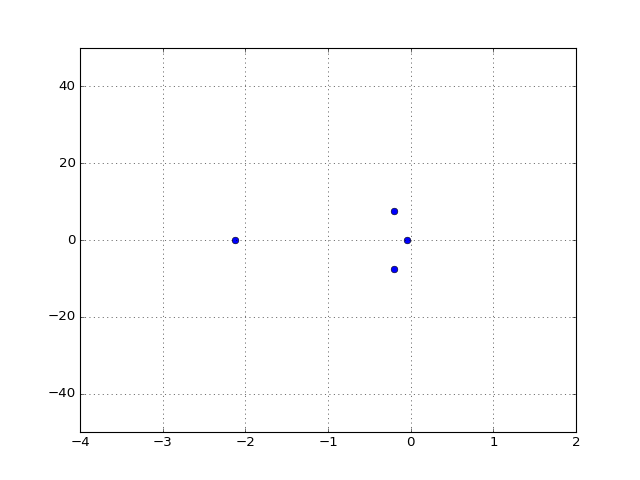

In [159]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_animated(True)
plt.xlim(-4, 2)
plt.ylim(-50, 50)
plt.grid(True)

poles = ax.plot([], 'o') 
#display(fig)


def update(p_m,v_f,D):
    lamb, p_val, q_val, V_val = autos(p_m,v_f,D,xi_0)
    poles[0].set_xdata(lamb.real)
    poles[0].set_ydata(lamb.imag)
    
    print('P   = {:2.2f}'.format(p_val))
    print('Q   = {:2.2f}'.format(q_val))
    print('V_t = {:2.2f}'.format(V_val))



sld_p_m = widgets.FloatSlider(min=0,max=1.2,step=0.01,value=xi_ini[9])
sld_v_f = widgets.FloatSlider(min=xi_ini[10]*0.5,max=xi_ini[10]*1.5,step=0.01,value=xi_ini[10])
sld_D = widgets.FloatSlider(min=0.0,max=5.0,step=0.01,value=0.1)
interaction = interactive(update,p_m=sld_p_m,v_f=sld_v_f,D=sld_D,continuous_update=False)    

In [160]:
display(interaction)

P   = 0.90
Q   = 0.25
V_t = 0.90


In [32]:
F_x.subs(params_run)

Matrix([
[0,     376.991118430775,      0,    0],
[0, -0.142857142857143*D,      0,    0],
[0,                    0, -0.125,    0],
[0,                    0,      0, -1.0]])

In [33]:
poles[0].set_xdata(2.0)

In [21]:
lamb = autos(1.0,0.0)

TypeError: autos() missing 2 required positional arguments: 'D' and 'xi_0'

In [ ]:
lamb

In [ ]:
poles[0].set_xdata(lamb.real)